In [1]:
# Author: Bowen Huang
# Created in May 23
#Import necessary modules
import pandas as pd
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def F2Cfun(f_list):
    "Return list in Celsius degree given Fahrenheit degree"
    return [(f -32)*5/9 for f in f_list]
def Cfm2Kgs(v_list):
    "Return list in Kg/s given Cubic-feet/min(mass air flow rate)"
    return [0.00056*v for v in v_list]
def AvgLst(v_list, dT):
    return [sum(v_list[i:i+dT])/dT for i in range(0,len(v_list),dT)]
def RMSEp(y_true, y_pred):
    # Normalized RMSE, normalized by (max - min) or mean
    y_t = np.array(y_true)
    y_p = np.array(y_pred)
#     return np.sqrt(np.mean(np.square((y_t - y_p)))) 
    mask = (y_t >= 0.001)
    return np.sqrt(np.mean(np.square((y_t[mask] - y_p[mask])/np.max(y_t[mask])))) #np.max(y_t)-np.min(y_t)

def linReg(Xtrain, ytrain, Xtest, ytest, Xtest_m, Xtest_tdis): #linear regression model
    flag = True # Print output or not
    global modelflag
    def predict_acc(Xt):
        yt = []
        for t in range(len(Xt)):
            Tz = reg.predict([Xt[t]])[0]
            if t < len(Xt)-1:
                Xt[t+1][0] = Tz
                Xt[t+1][2] = Xtest_m[t+1]*(Xtest_tdis[t] - Tz)
            yt.append(Tz)
        return np.array(yt)
    
    #performs linear regression for training data
    reg = LinearRegression().fit(Xtrain, ytrain)
    if flag:
        #outputs r^2 scores
        print('Linear regression scores: ', reg.score(Xtrain, ytrain), reg.score(Xtest,ytest))
    
    #predicts output for training data based on regression
    yfit = reg.predict(Xtrain)
    
    err_train = yfit-ytrain #calculates error for training data
    RMSE_train=RMSEp(ytrain,yfit)#np.sqrt(mean_squared_error(ytrain,yfit)) #calculates RMSE for training
    
    #predicts output for test data based on regression
    ######### Compute 1 day multiple days averaged(check if significant change)
    coeff = np.concatenate((reg.coef_,[reg.intercept_]))
    
    if modelflag == 1:
        yresults = predict_acc(Xtest)
        ylabel = 'Zone temperature ($^\circ$C)'
    elif modelflag == 2:
        yresults = reg.predict(Xtest)
        ylabel = 'Mass flow rate (kg/s)'
    
    if flag:
        for i in range(len(coeff)):
            print("{:.16f}".format(coeff[i]))
    
    err_test = yresults-ytest #error for test data
    if modelflag == 1:
        RMSE_test = np.sqrt(mean_squared_error(ytest,yresults))
    elif modelflag == 2:
        RMSE_test= RMSEp(ytest,yresults)#np.sqrt(mean_squared_error(ytest,yresults)) #RMSE for test data
    
    if flag:
        #printts relevant error values
        print('\nRMSE: ', RMSE_train, RMSE_test)
        print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
        print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
        print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
    
        #initializes arrays for plotting
        t1 = np.linspace(1, 21, len(ytrain)) #array of days for training data
        t2 = np.linspace(1, 7, len(ytest)) #array of days for test data

        #plots linear regression training results
        plt.figure(1)
        plt.plot(t1, ytrain, 'o', mfc ='none', label='training data')
        plt.plot(t1, yfit, label='linear regression results')
        plt.xlabel('Day')
        plt.ylabel(ylabel)
        plt.title('Linear regression training results')
        plt.legend()


        #plots linear regression training % error
        plt.figure(2)
        plt.plot(t1, 100*err_train/ytrain, label='linear regression results')
        plt.xlabel('Day')
        plt.ylabel('% Error')
        plt.title('Linear regression training results')
        plt.legend()

        #plots linear regression test results
        plt.figure(3)
        plt.plot(t2, ytest, 'o', mfc ='none', label='test data')
        plt.plot(t2, yresults, label='linear regression results')
        plt.title('Linear regression test results')
        plt.xlabel('Day')
        plt.ylabel(ylabel)
        plt.legend()
        plt.show()
        #plots linear regression test % error
        plt.figure(4)
        plt.plot(t2, 100*err_test/ytest, label='linear regression results')
        plt.title('Linear regression test results')
        plt.xlabel('Day')
        plt.ylabel('% Error')
        plt.legend()
    
    return yresults, coeff, RMSE_test

In [2]:
rawdata = pd.read_csv('building1.csv')
RoomName = ['002','004','100','102','104','105','107','108', \
            '112','116','118','119','120','121','123A','123B',\
            '127A','127B','129','133','136','142','143','150']
# RoomName = RoomName[1:9]
# 002 004 100 121 missing lighting power
N = len(RoomName)
print("Total number of rooms:",N)

Total number of rooms: 24


In [3]:
Ttpower = rawdata['WholeBuildingPower']
Ts  = rawdata['Date'].tolist()
TOA = rawdata['OurdoorAirTemperature'].tolist()
TOA = F2Cfun(TOA)
Tzon = []
Tset = []
Mdot = []
Pfan = []
for z in range(N):
    rName = RoomName[z]
    Tzon.append(rawdata['ZoneTemperature_{0}'.format(rName)].tolist()) # unit in Fahrenheit degree
    Tset.append(rawdata['ZoneCoolingTemperatureSetpoint_{0}'.format(rName)].tolist()) # unit in Fahrenheit degree
    Mdot.append(rawdata['SupplyAirFlow_{0}'.format(rName)].tolist()) # unit in cubic-feet/min
#     Pfan.append(rawdata['WholeBuildingPower'] - rawdata['LightingPower_{0}'.format(rName)])
Tzon = [F2Cfun(flist) for flist in Tzon]
Tset = [F2Cfun(flist) for flist in Tset]
Mdot = [Cfm2Kgs(vlist) for vlist in Mdot]
Tdis1 = rawdata['DischargeAirTemperature_112'].tolist()
Tdis1 = F2Cfun(Tdis1)
Tdis2 = rawdata['DischargeAirTemperature_116'].tolist()
Tdis1 = F2Cfun(Tdis2)

Total Number of Rooms is 24
Linear regression scores:  0.9811555220037474 0.9814550581738012
-0.0042024523212540
-0.0002260927111631
-0.1252702346876369
3.3859871674721433

RMSE:  0.10224105090711802 0.10075843841087409

Max % error:  inf inf

Mean % error:  nan nan

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
/Users/huan926/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


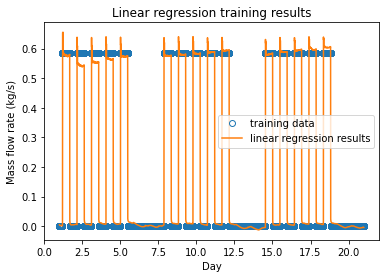

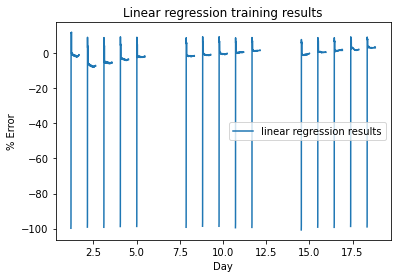

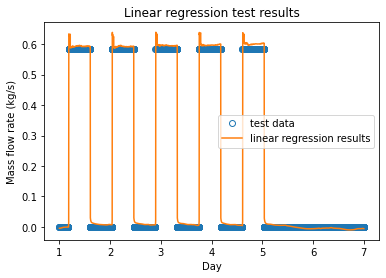

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
/Users/huan926/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.9809539632407411 0.9814817935565203
-0.0064382631963913
-0.0000680738866651
-0.1683835319250049
4.5540940828157783

RMSE:  0.1034442442291133 0.10132324446926226

Max % error:  inf inf

Mean % error:  nan nan

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


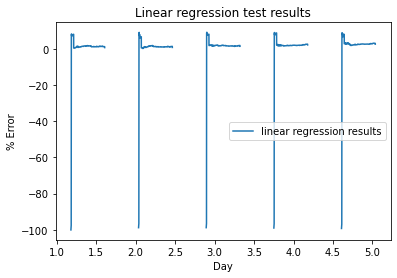

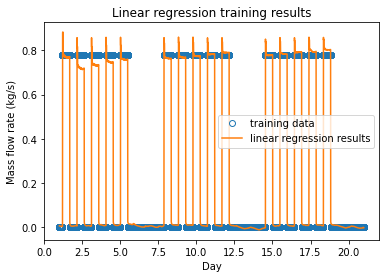

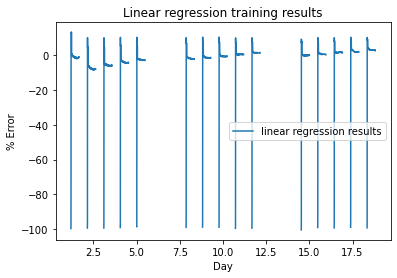

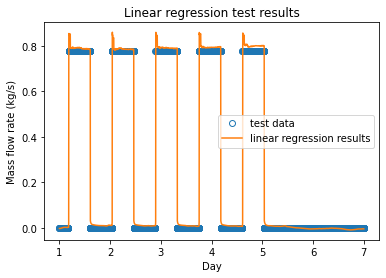

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.24175550921720712 0.004153970598162027
0.0020634012615865
0.0000993383436586
-0.0023170166355840
0.0332003973177556

RMSE:  0.09989589590987863 0.08451037959754495

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


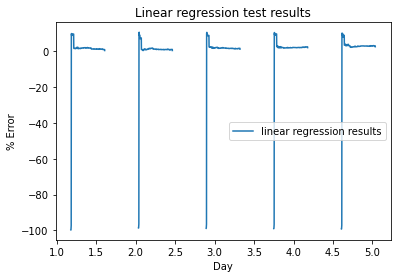

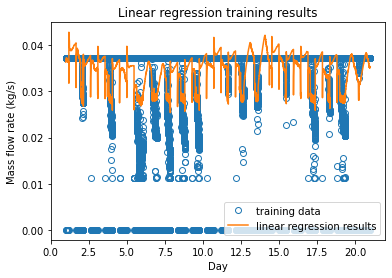

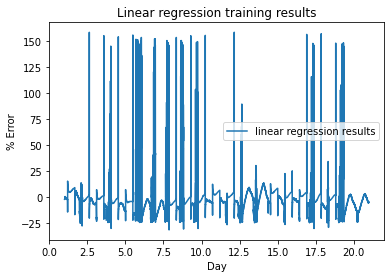

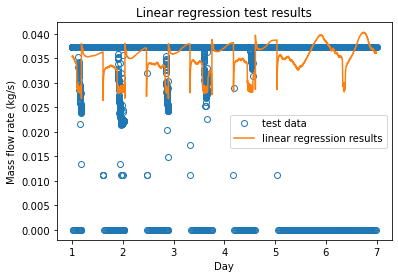

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.5834677159894187 0.4721197655981496
-0.0084873481528606
0.0072409640163541
-0.0323963100123743
1.0863241416515013

RMSE:  0.15141421534767244 0.17589997654581083

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


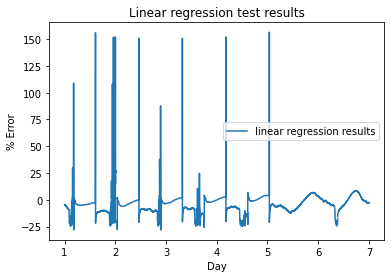

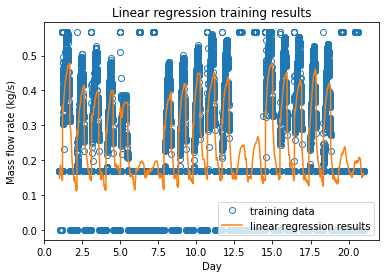

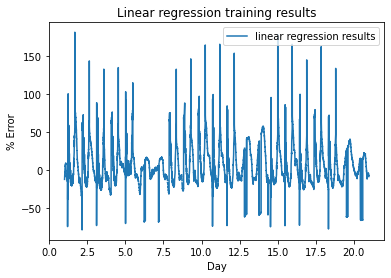

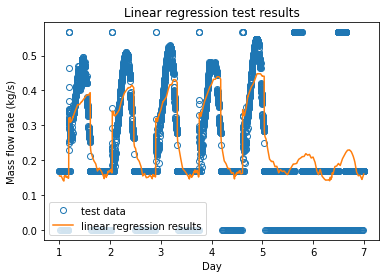

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.8565527505075226 0.8953939899008588
0.0008619568068331
-0.0001373179729294
-0.0070877533467502
0.1807804947557184

RMSE:  0.09310134034244441 0.07745286447748474

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


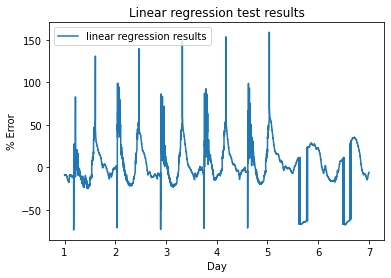

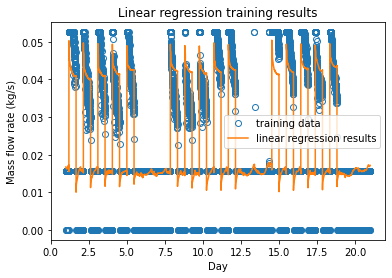

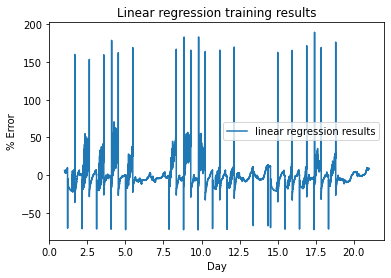

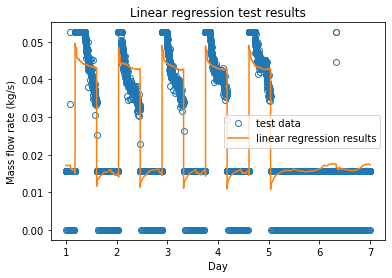

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.5857431441868579 0.502495017008996
-0.0037590265254637
0.0079767458853206
-0.0278711892222585
0.8234909551251640

RMSE:  0.15339953773728218 0.1691469918424501

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


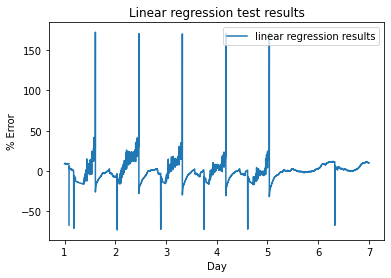

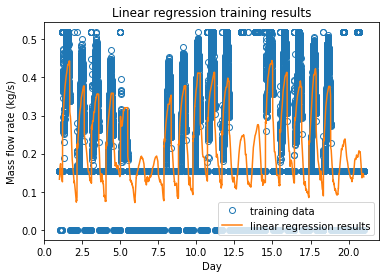

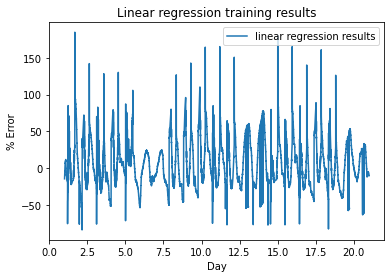

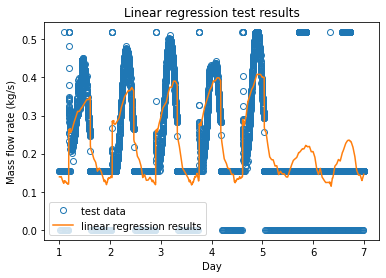

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


Linear regression scores:  0.814856505993816 0.8580896143499724
-0.0004637832567260
0.0002721752043839
-0.0065780900388516
0.1975527865554867

RMSE:  0.0939855142053458 0.07564016434250088

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


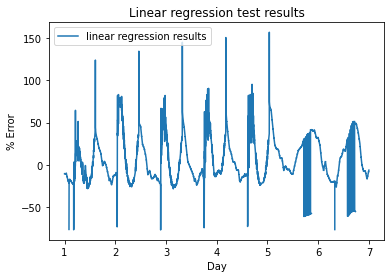

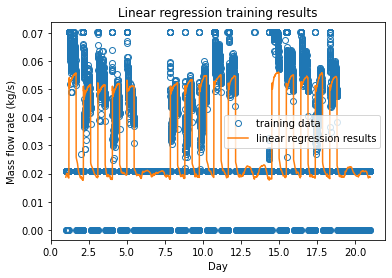

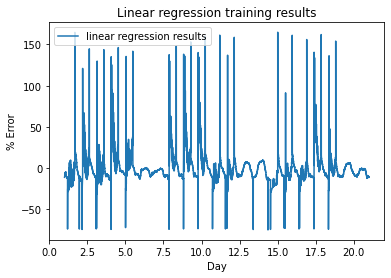

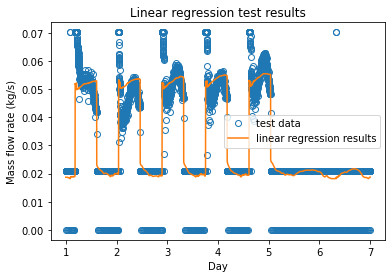

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.46454294246248284 0.40829554232160903
0.0078772709505591
0.0003257240458382
-0.0383067704070917
0.8956319176732890

RMSE:  0.22696901218742818 0.2386216160921732

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


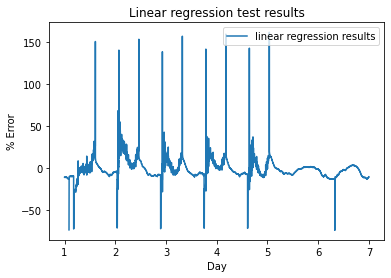

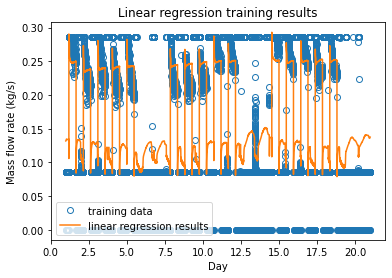

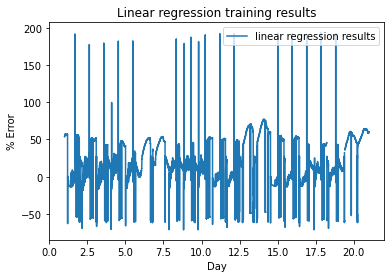

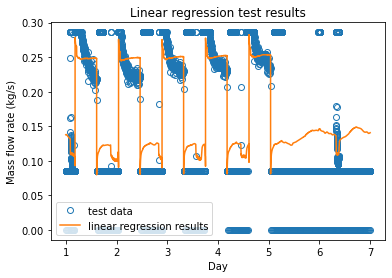

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.47965709308956705 0.1385424136237985
0.0145834010256611
0.0014919701744955
-0.0255623560863375
0.3708309111899782

RMSE:  0.13469985696402298 0.13455130362729703

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


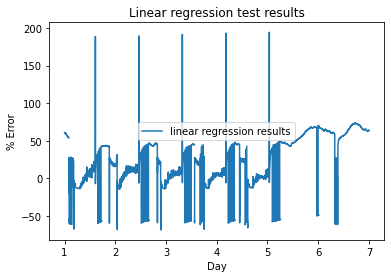

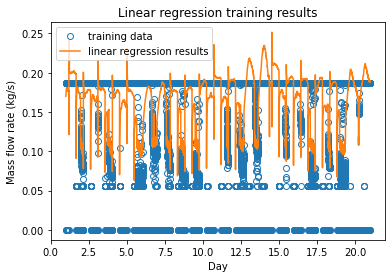

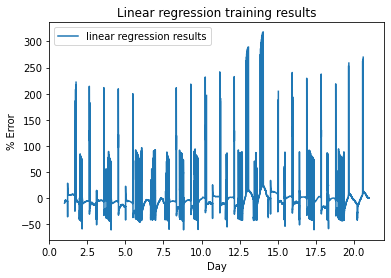

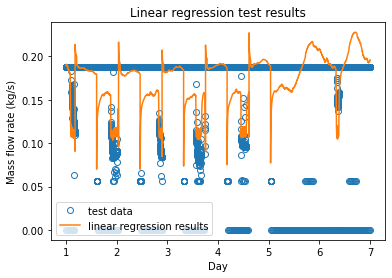

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


Linear regression scores:  0.781626950656898 0.842492523072298
0.0006404082296246
-0.0000988991313809
-0.0041212178568889
0.1039293353492826

RMSE:  0.10248710577052092 0.08278161546322339

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


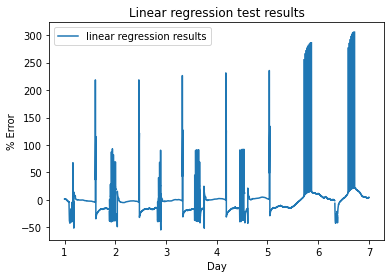

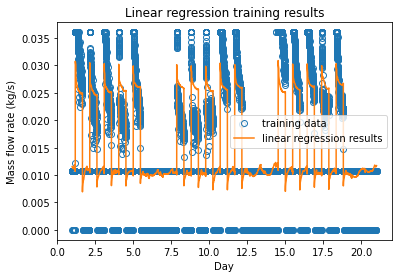

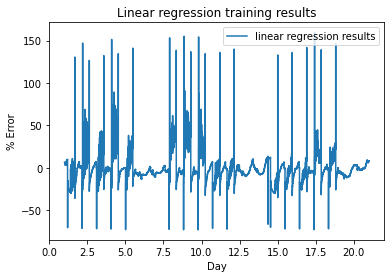

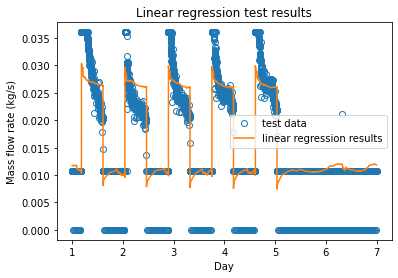

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.8442072125824832 0.8696150238374899
0.0016486848335005
-0.0003387130788689
-0.0254478157533736
0.6911150283089634

RMSE:  0.09032756442308518 0.08475638135905203

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


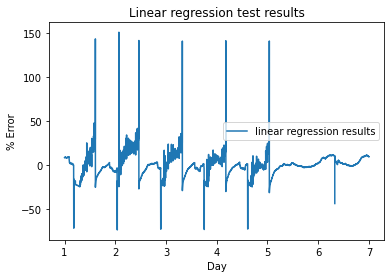

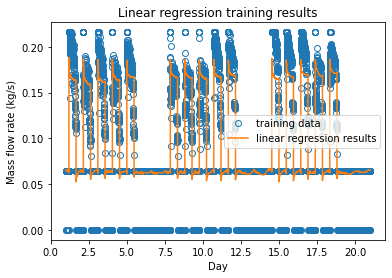

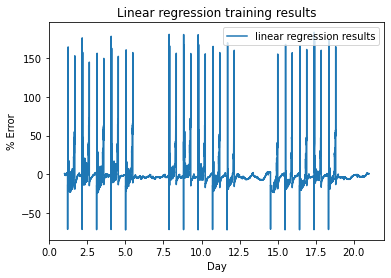

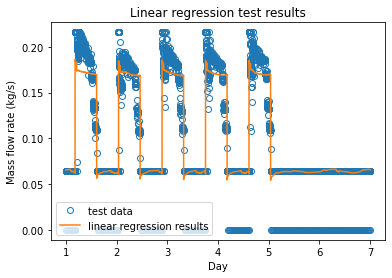

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.8663192862346047 0.8923692067347192
0.0007526869536371
-0.0001591622330300
-0.0051084532013785
0.1291450355353368

RMSE:  0.08019018868414493 0.07309362876219716

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


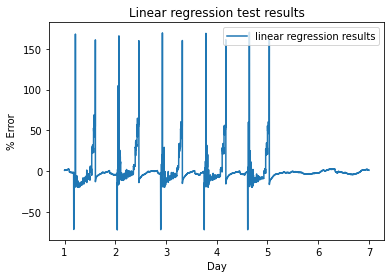

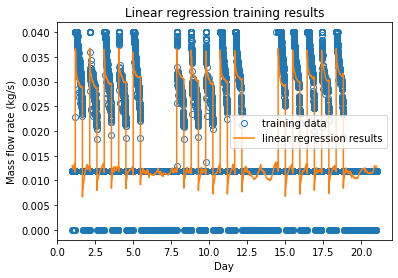

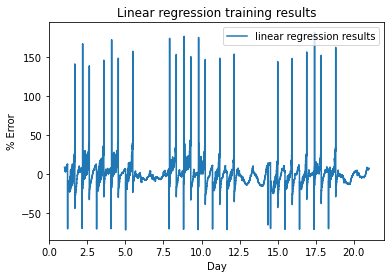

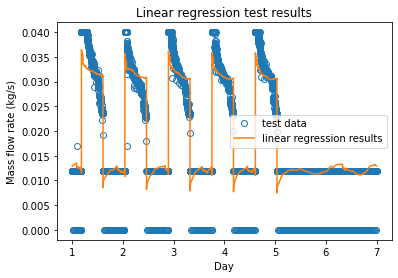

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.8486016560478269 0.885913840753102
0.0009747571457059
-0.0001802208534915
-0.0053481953842307
0.1306564493501940

RMSE:  0.08689799782959343 0.07496783868454975

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


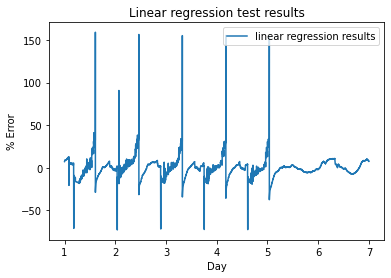

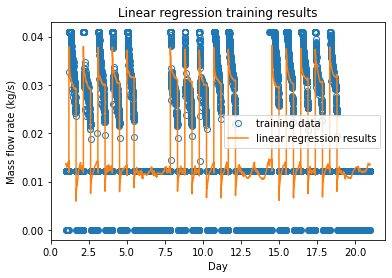

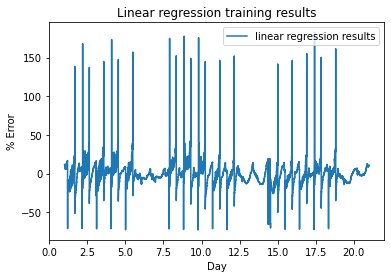

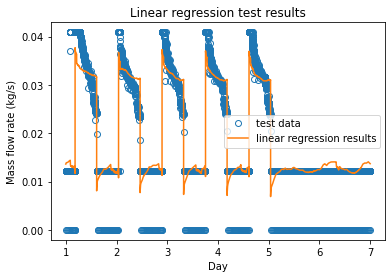

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.855509270588395 0.8928333205558474
0.0001438245737636
0.0000655652906236
-0.0127605425366317
0.3629115044300433

RMSE:  0.07617857014682815 0.06428445898532058

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


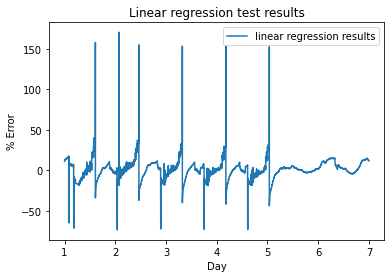

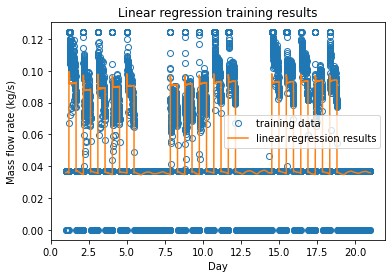

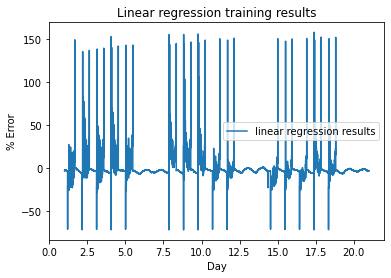

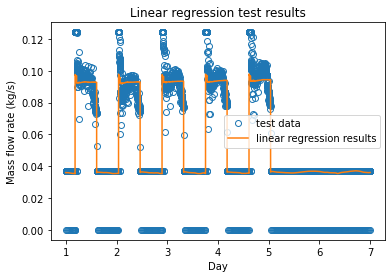

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.47896984813158816 0.43478003079397687
0.0257856334417224
-0.0031890470441736
-0.0428787701524538
0.6290997354619706

RMSE:  0.17752306970539164 0.19284329981922613

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


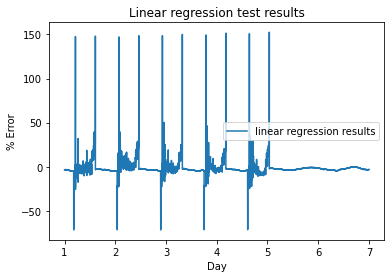

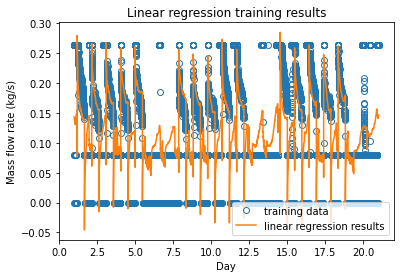

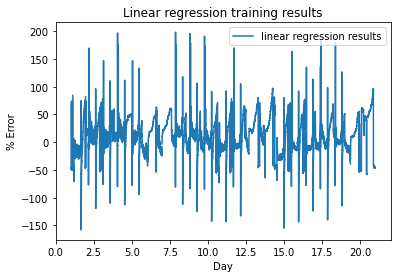

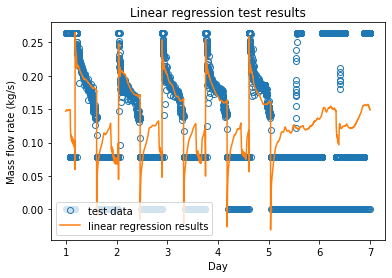

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.5037170537336604 0.4533062125497943
0.0243249374101518
-0.0030164167336409
-0.0434352507742471
0.6779968572999155

RMSE:  0.17357692339534644 0.19211143096660066

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


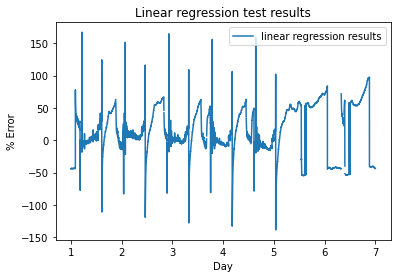

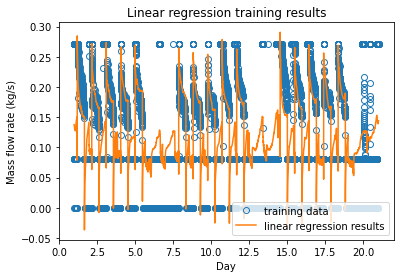

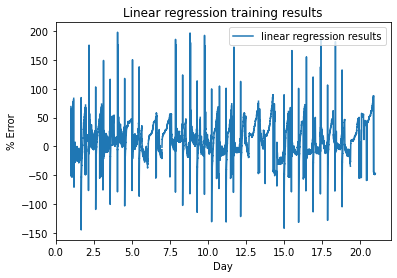

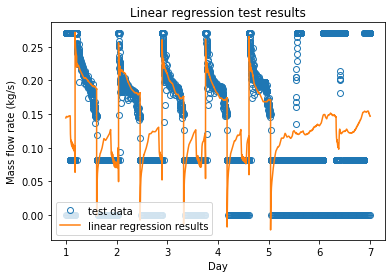

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.7837577337755741 0.843015550536893
-0.0046876562268440
0.0018609553850487
-0.0527636367491702
1.6663688815731970

RMSE:  0.07241429191674545 0.05766349920592819

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


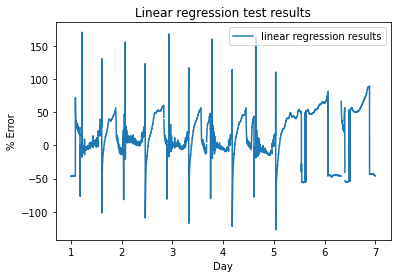

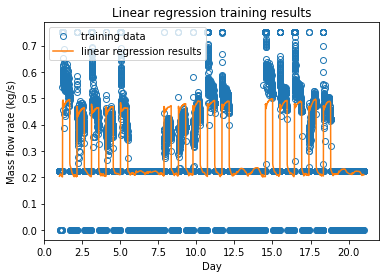

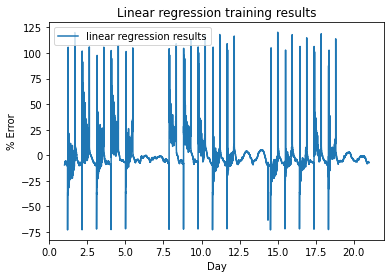

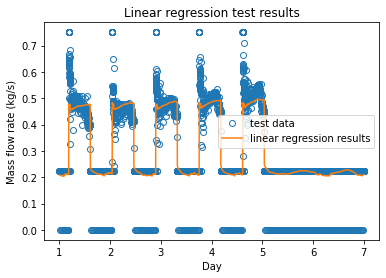

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.273222580652714 0.3227093944257945
0.0386579858721861
0.0071263161234755
-0.0934957163035874
1.8517462084892349

RMSE:  0.22571044537232182 0.20227277835064475

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


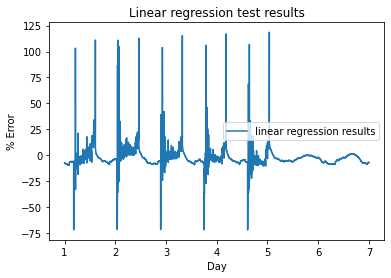

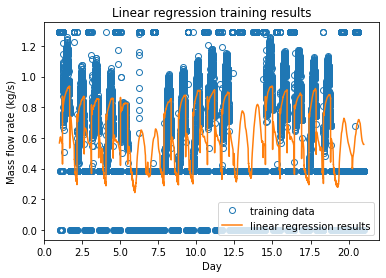

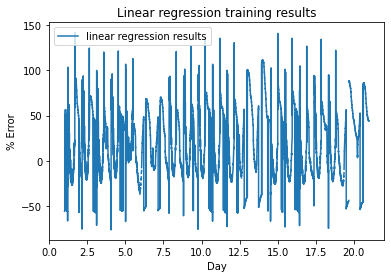

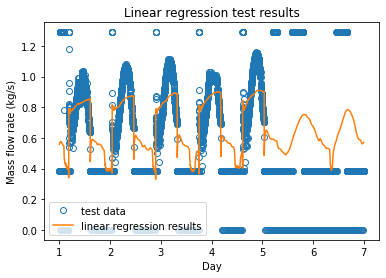

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.735209023203915 0.849479633074654
0.0064792769169384
-0.0008914790136284
-0.0191192305681854
0.3981317215107587

RMSE:  0.11810471464039597 0.07948538366967091

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


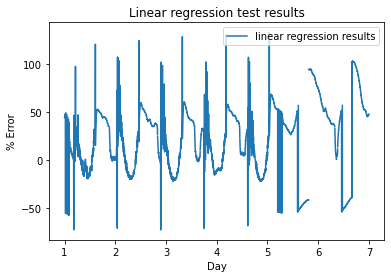

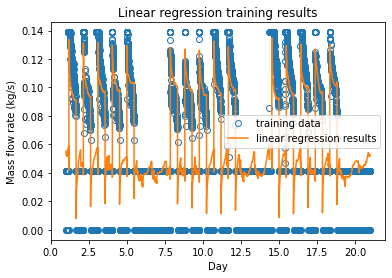

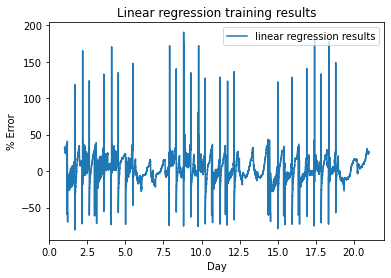

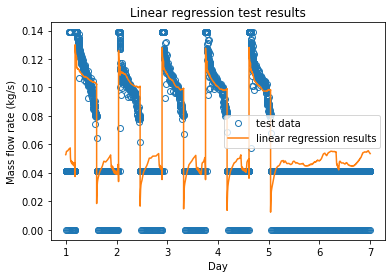

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.5069549439290173 0.39089859430414575
0.0096838093593634
0.0014751636483395
-0.0009792225373120
-0.1534403889759210

RMSE:  0.20572096265348627 0.22572365492721216

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


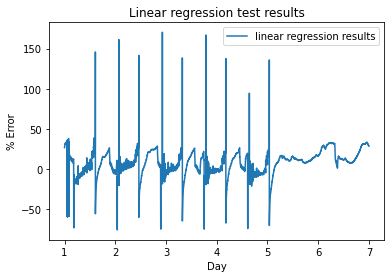

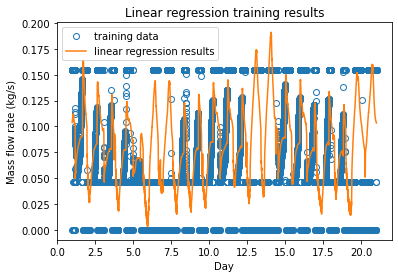

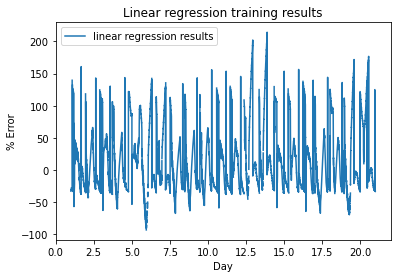

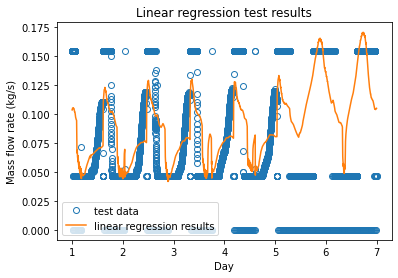

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
/Users/huan926/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in

Linear regression scores:  0.5495462303622829 0.4075425575441115
0.0782453655032407
0.0133537912488717
-0.0257702454006556
-1.1337545958053425

RMSE:  0.2517666469672489 0.2862535534399277

Max % error:  inf inf

Mean % error:  nan inf

Mean mag % error:  inf inf


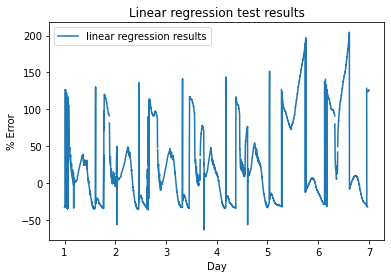

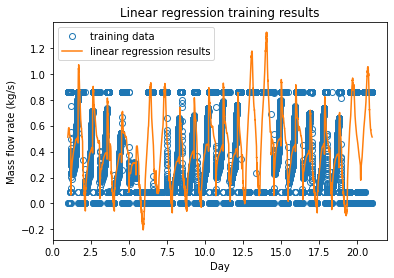

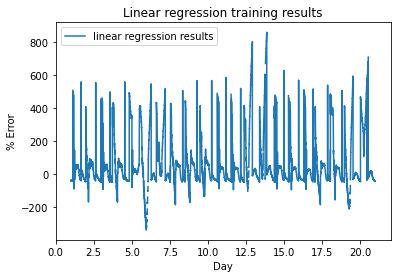

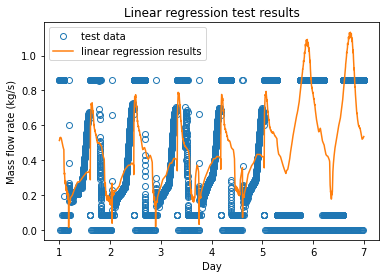

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.5820522567094787 0.5238913274925816
0.0079272062902830
0.0029083094430485
0.0005410631276617
-0.1658304509595064

RMSE:  0.1857268800735179 0.19745974096471602

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


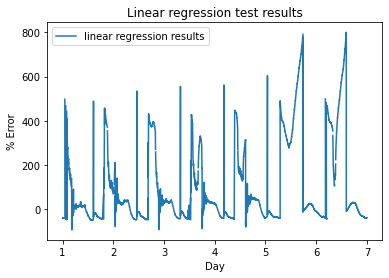

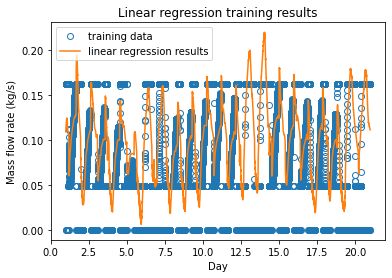

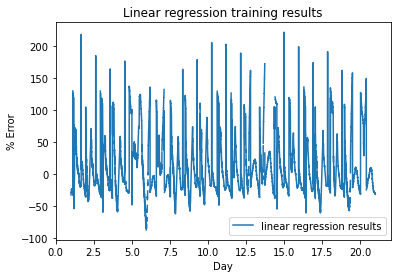

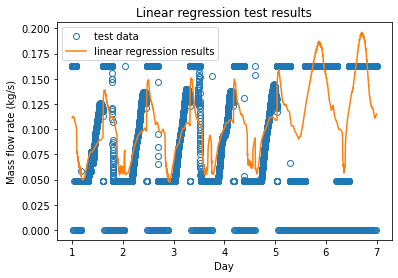

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.427246983532644 0.37489125222166597
0.0039193501732040
0.0014697166595102
-0.0146784784574089
0.3222448240895551

RMSE:  0.20465166442279062 0.2085727348254369

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


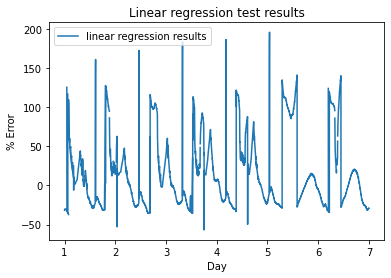

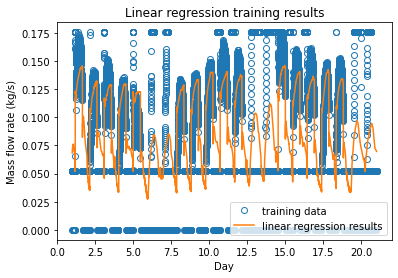

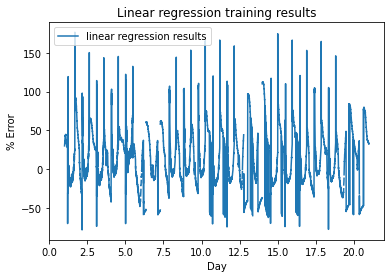

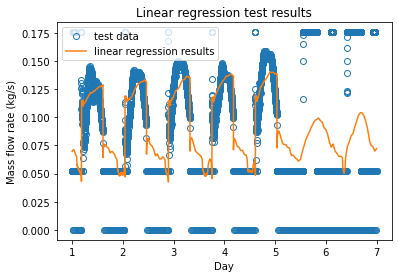

<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-1-f0dadb5d9241>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-1-f0dadb5d9241>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-1-f0dadb5d9241>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


Linear regression scores:  0.7936732942514944 0.84238030916438
0.0045261647140188
-0.0007148219947302
-0.0506269416437715
1.3750344971667259

RMSE:  0.08490261706056364 0.07235975294050517

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


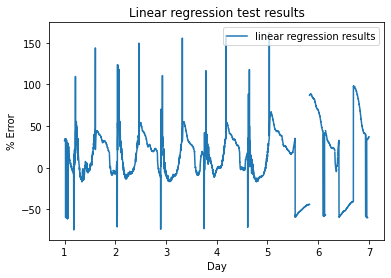

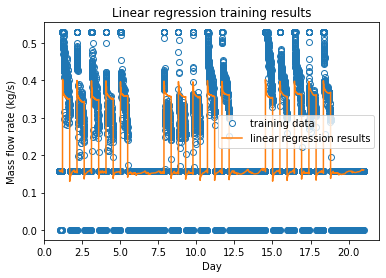

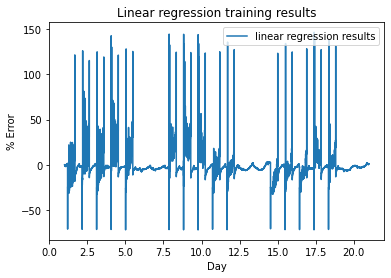

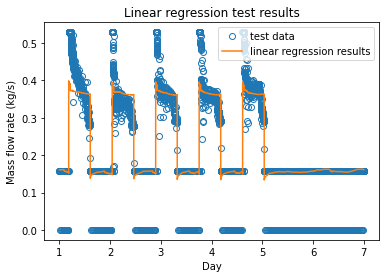

Zone Temperature prediciton RMSE is 6.868091566621848e-16
Mass flow prediciton RMSE is 0.1355222804904004
Zone Temperature prediciton RMSE is 6.868091566621848e-16


<ipython-input-1-f0dadb5d9241>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


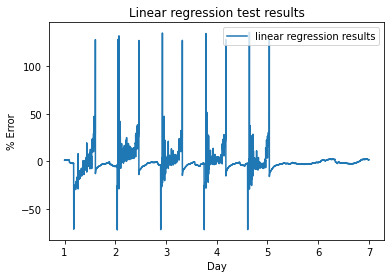

In [4]:
%matplotlib inline 
#qt

Ttotal = 40320
##########################################################
## Set time resolution to 1 or 60(min)
##########################################################
dT = 1# Time interval
##########################################################
## Set model option 1 or 2
##########################################################
modelflag = 2
print('Total Number of Rooms is',N)
RMSE_Ttt = 0
RMSE_Mtt = 0
debugflag = 0 # No printout in linear regression

T0 = []
# Tstart = [1,4,10,24,35,78,86,123,137]
Tstart = [137]
Tstart = [tt+12 for tt in Tstart]
## Start Time from 0:00, 12:00pm 
for tt in Tstart:
    T0.append(int(24*(60/dT)*21+tt*(60/dT)))
Tlen = 24*int(60/dT)
Ttest = []
for t0 in T0:
    Ttest.append(list(range(t0,t0+Tlen)))
RMSE_Ttot = 0
for Tind in range(len(Tstart)):
    for Zid in range(N):
        Mdot_z= Mdot[Zid]
        Tset_z= Tset[Zid]
        Tzon_z= Tzon[Zid]
        Tdis  = [12.8]*len(Tdis1) # Constant discharge temperature 12.8 Degree Celsius

        Tzonm = [sum(Tzon_z[i:i+dT])/dT for i in range(0,len(Tzon_z),dT)]
        TOAm  = [sum(TOA[i:i+dT])/dT for i in range(0,len(TOA),dT)]
        Mdotm = [sum(Mdot_z[i:i+dT])/dT for i in range(0,len(Mdot_z),dT)]
        Tsetm = [sum(Tset_z[i:i+dT])/dT for i in range(0,len(Tset_z),dT)]
        Tdism = [sum(Tdis[i:i+dT])/dT for i in range(0,len(Tdis),dT)]

        Xtrain = []
        Xtest = []
        Xtest_m = []
        Xtest_tdis = []
        # Model 1: Tz' = a1*Tz + a2*Toa + a3*mdot(Tdis - Tz) + a4
        # Model 2: mdot = a1*Tz + a2*Toa + a3*Tset + a4
        for t in range(1,int(Ttotal/dT)):
            if (t < 24*(60/dT)*21): # Use first 3 weeks as training data
                if modelflag == 1:
                    Xtrain.append([Tzonm[t-1], TOAm[t-1], Mdotm[t]*(Tdism[t-1] - Tzonm[t-1])])
                elif modelflag == 2:
                    Xtrain.append([Tzonm[t-1], TOAm[t], Tsetm[t]])
            else:
                if modelflag == 1:
                    if t in Ttest[Tind]: # Manually change the Ttest then average RMSE_T
                        Xtest.append([Tzonm[t-1], TOAm[t-1], Mdotm[t]*(Tdism[t-1] - Tzonm[t-1])])
                elif modelflag == 2:
                    Xtest.append([Tzonm[t-1], TOAm[t], Tsetm[t]])
                Xtest_m.append(Mdotm[t])
                Xtest_tdis.append(Tdism[t-1])
        if modelflag == 1:
            ym = Tzonm
        elif modelflag == 2:
            ym = Mdotm
        ytrain= ym[1:(len(Xtrain)+1)]
        ytest = ym[(len(Xtrain)+1):len(Xtrain)+len(Xtest)+1]

        yrlr, coeff, RMSE_test = linReg(Xtrain, ytrain, Xtest, ytest, Xtest_m, Xtest_tdis)
        if modelflag == 1:
            RMSE_Ttt = RMSE_Ttt + RMSE_test
    #         Xt_np = np.array(Xtest)
    #         Xt1_np = np.array(Xtest_T)
    #         Ypred_np = np.array(yrlr)
    #         Mz_pred = (Ypred_np - coeff[0]*Xt_np[:,0] - coeff[1]*Xt_np[:,1]-coeff[3])/coeff[2]/Xt1_np
            RMSE_Mtt = 0 #RMSE_Mtt + RMSEp(Xt_np[:,2]/Xt1_np,Mz_pred)#np.sqrt(mean_squared_error(Xt_np[:,2]/Xt1_np,Mz_pred))
        elif modelflag == 2:
            RMSE_Mtt = RMSE_Mtt + RMSE_test
            Xt_np = np.array(Xtest)
            Ypred_np = np.array(yrlr)
            Tz_pred = (Ypred_np - coeff[1]*Xt_np[:,1] - coeff[2]*Xt_np[:,2]-coeff[3])/coeff[0]
            RMSE_Ttt = RMSE_Ttt + RMSEp(Xt_np[:,0],Tz_pred)#np.sqrt(mean_squared_error(Xt_np[:,0],Tz_pred))
    #     RMSE_Ptt = RMSE_Ptt + RMSE_P

    RMSE_Ttt = RMSE_Ttt/N # Average over all rooms
    RMSE_Mtt = RMSE_Mtt/N
    RMSE_Ttot = RMSE_Ttot + RMSE_Ttt
    print("Zone Temperature prediciton RMSE is",RMSE_Ttt)
    print("Mass flow prediciton RMSE is",RMSE_Mtt)
RMSE_Ttot = RMSE_Ttot/len(Tstart)
print("Zone Temperature prediciton RMSE is",RMSE_Ttot)

|dT= 1|              |
|---------|---------|
|Time period 1:|    2.036119848146391|
|Time period 2:|   3.3266630454612582|
|Time period 3:|    3.5430330659625793|
|Time period 4:|    1.7355829560805711|
|Time period 5:|    3.8228522465531594|
|Time period 6:|    3.069715525288094|
|Time period 7:|    3.5215623197062196|
|Time period 8:|    2.5448713493573774|
|Time period 9:|    7.247195672668298|
|Time period 10:|    2.5190519429581557|
|Average: | |

|dT= 60   |         |
|---------|---------|
|Time period 1:|    1.0775063688227344|
|Time period 2:|    1.516429913271723|
|Time period 3:|    2.397786684591065|
|Time period 4:|    1.005062503422326|
|Time period 5:|    2.382451326587289|
|Time period 6:|    2.3608151169382148|
|Time period 7:|    2.013007142159245|
|Time period 8:|    1.3671103166714278|
|Time period 9:|    2.032621355378222|
|Time period 10:|    1.0870957111098922|
|Average: | |

In [ ]:
# # Training the Electric power consumption model
# Mtot1 = [0]*len(Mdot_z)
# Mtot2 = [0]*len(Mdot_z)
# Mtot3 = [0]*len(Mdot_z)
# Tr = 

# for Zid in range(N):
#     Mdot_z= Mdot[Zid]
#     Mtot1 = [Mtot1[t] + Mdot_z[t] for t in range(len(Mtot1))
#     Mtot2 = [Mtot2[t] + Mdot_z[t]**2 for t in range(len(Mtot2))
#     Mtot3 = [Mtot3[t] + Mdot_z[t]**3 for t in range(len(Mtot3))
#     Tset_z= Tset[Zid]
#     Tzon_z= Tzon[Zid]
#     Tdis  = [12.8]*len(Tdis1) # Constant discharge temperature 12.8 Degree Celsius

In [ ]:
# import numpy as np
# from sklearn.linear_model import LinearRegression
# X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# # y = 1 * x_0 + 2 * x_1 + 3
# y = np.dot(X, np.array([1, 2])) + 3
# reg = LinearRegression().fit(X, y)
# reg.score(X, y)
d# reg.coef_

# reg.intercept_

# yy = reg.predict([X[-1]])
# aa = False
# print(aa)
a = [1,2,4,5,10,11,-1]
a = np.array(a)
mask = (a<=1)
b = a[mask]
print(b)